In [2]:
print('?')

?


In [1]:
import os
import http
#import lightkurve as lk
from lightkurve import search_tesscut
from lightkurve import DesignMatrix
from lightkurve import DesignMatrixCollection
from lightkurve import RegressionCorrector
from lightkurve import LightCurve
import numpy as np
import re
import sys
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import patches
from astroquery.skyview import SkyView
from astropy.coordinates import get_icrs_coordinates
from astropy.coordinates.name_resolve import NameResolveError
from astropy.coordinates import SkyCoord
from astropy.wcs import *
from astropy import units as u
import astropy.io.fits as pyfits
from io import StringIO
plt.ion()
#input_coord_split = re.split(r"\s+|,|\s*,\s*", input_coord_string)
print("dusted 2")

dusted 2


In [6]:
primary_correction_method = 3
tpf_width_height = 30
additive_pca_num = 2
multiplicative_pca_num = 2
pca_only_num = 2
lowest_dss_contour = 0.5 #irrelevant for analysis
sys_threshold_orig = 0.2
max_masked_regions = 30
plot_index = 300
bf_threshold = 1.5 #default 1.5
prop_error_flag = True

#aperture
pixel_threshold = 2.4 #times the background flux (for background_percentile = 20)
int_pixel_threshold = 2.4 #same but for integrated flux instead of at plot_index
background_percentile = 20 #percentile determining background for pixel threshold
decrease_pixel_threshold = 0.05 #reduce pixel threshold by this if central pixel is already below threshold
decrease_int_pixel_threshold = 0.05 #same for integrated flux
shift_plot_index = 50 #shift index by this if there are zero or negative flux values
endlength = 200 #usual length of systematics at the end
adjacent_ratio_threshold = 1.5 #ratio of bridge pixel flux to adjacent pixel flux, rejected if higher
fraction_of_central = 1/2 #for gradients in galaxy: include pixels with adjacent pixel above this fraction

#mask
#maskout_threshold = 20 #times the mean absolute value of the additive component
#maskend_threshold = 0.8 #fraction of sys_threshold determining end of a mask
min_bkg_length = 2/3 #acceptable unmasked fraction of the background before starting with new sys_threshold
increase_sys_threshold = 0.05 #increase sys_threshold by this when too much was masked out
min_mask_gap = 10 #gaps smaller than this between values above sys_threshold are included in masks
maskextension = 2 #number of timesteps added before and after each mask

In [3]:
#new flood fill including rejecting bridge pixels
def flood_fill_bridge(x, y, visited, row_col_coords_init, threshold, pixel_threshold, central):
    if len(row_col_coords_init) == 0 and tpf.flux[plot_index].value[x][x] < threshold:
        pixel_threshold += -decrease_pixel_threshold
        threshold = background_flux * pixel_threshold
        print('flux of central pixel is too low, no aperture mask selected')
        #print('flux of central pixel is too low, set new pixel threshold to',pixel_threshold)
        flood_fill_bridge(x, y, visited, row_col_coords_init, threshold, pixel_threshold, central)
    elif (0 <= x < len(visited[0])
        and 0 <= y < len(visited)
        and not visited[y][x]
        and tpf.flux[plot_index].value[y][x] > threshold):
        # Calculate the direction from the central pixel to the current pixel
        direction_x = x - central
        direction_y = y - central
        # Calculate the adjacent pixel coordinates in the direction of the central pixel
        adj_x = x - (0 if abs(direction_x) < abs(direction_y) else 1 if direction_x > 0 else -1 if direction_x < 0 else 0)
        adj_y = y - (0 if abs(direction_y) < abs(direction_x) else 1 if direction_y > 0 else -1 if direction_y < 0 else 0)
        # Check if the adjacent pixel is within bounds
        if 0 <= adj_x < len(visited[0]) and 0 <= adj_y < len(visited):
            if x == central and y == central:
                visited[y][x] = True
            # Check if the current pixel's flux is not more than 1 sigma higher than the adjacent pixel's flux
            #if tpf[y, x] <= tpf[adj_y, adj_x] + sigma or tpf[adj_y, adj_x] >= tpf[central, central] - sigma:
            if (visited[adj_y][adj_x]
                and ( tpf.flux[plot_index].value[y][x] <=  tpf.flux[plot_index].value[adj_y][adj_x] * adjacent_ratio_threshold
                or tpf.flux[plot_index].value[adj_y][adj_x] >= tpf.flux[plot_index].value[central][central] * fraction_of_central)):
                visited[y][x] = True
                #print('included (',y,',',x,') with flux',tpf[y,x],'compared to (',adj_y,',',adj_x,') with flux',tpf[adj_y,adj_x])
                row_col_coords_init.append((x, y))
                # Recursively check neighbouring pixels
                flood_fill_bridge(x + 1, y, visited, row_col_coords_init, threshold, pixel_threshold, central)
                flood_fill_bridge(x - 1, y, visited, row_col_coords_init, threshold, pixel_threshold, central)
                flood_fill_bridge(x, y + 1, visited, row_col_coords_init, threshold, pixel_threshold, central)
                flood_fill_bridge(x, y - 1, visited, row_col_coords_init, threshold, pixel_threshold, central)
                
#same as flood_fill_bridge, but for integrated flux values
def flood_fill_integrated(x, y, visited, row_col_coords_init, int_threshold, int_pixel_threshold, central):
    if len(row_col_coords_init) == 0 and integrated_flux[x][x] < int_threshold:
        int_pixel_threshold += -decrease_int_pixel_threshold
        int_threshold = int_background_flux * int_pixel_threshold
        print('flux of central pixel is too low, no aperture mask selected')
        #print('flux of central pixel is too low, set new pixel threshold to',pixel_threshold)
        #flood_fill_bridge(x, y, visited, row_col_coords_init, threshold, pixel_threshold, central)
    elif (0 <= x < len(visited[0])
        and 0 <= y < len(visited)
        and not visited[y][x]
        and integrated_flux[y][x] > int_threshold):
        # Calculate the direction from the central pixel to the current pixel
        direction_x = x - central
        direction_y = y - central
        # Calculate the adjacent pixel coordinates in the direction of the central pixel
        adj_x = x - (0 if abs(direction_x) < abs(direction_y) else 1 if direction_x > 0 else -1 if direction_x < 0 else 0)
        adj_y = y - (0 if abs(direction_y) < abs(direction_x) else 1 if direction_y > 0 else -1 if direction_y < 0 else 0)
        # Check if the adjacent pixel is within bounds
        if 0 <= adj_x < len(visited[0]) and 0 <= adj_y < len(visited):
            if x == central and y == central:
                visited[y][x] = True
            # Check if the current pixel's flux is not more than 1 sigma higher than the adjacent pixel's flux
            #if tpf[y, x] <= tpf[adj_y, adj_x] + sigma or tpf[adj_y, adj_x] >= tpf[central, central] - sigma:
            if (visited[adj_y][adj_x]
                and ( integrated_flux[y][x] <=  integrated_flux[adj_y][adj_x] * adjacent_ratio_threshold
                or integrated_flux[adj_y][adj_x] >= integrated_flux[central][central] * fraction_of_central)):
                visited[y][x] = True
                #print('included (',y,',',x,') with flux',tpf[y,x],'compared to (',adj_y,',',adj_x,') with flux',tpf[adj_y,adj_x])
                row_col_coords_init.append((x, y))
                # Recursively check neighbouring pixels
                flood_fill_bridge(x + 1, y, visited, row_col_coords_init, int_threshold, int_pixel_threshold, central)
                flood_fill_bridge(x - 1, y, visited, row_col_coords_init, int_threshold, int_pixel_threshold, central)
                flood_fill_bridge(x, y + 1, visited, row_col_coords_init, int_threshold, int_pixel_threshold, central)
                flood_fill_bridge(x, y - 1, visited, row_col_coords_init, int_threshold, int_pixel_threshold, central)

#for aperture mask only around the central object
def flood_fill(x, y, visited, row_col_coords_init, threshold, pixel_threshold):
    if len(row_col_coords_init) == 0 and tpf.flux[plot_index].value[x, x] < threshold:
        pixel_threshold += -decrease_pixel_threshold
        threshold = pixmin * pixel_threshold
        print('flux of central pixel is too low, set new pixel threshold to',pixel_threshold)
        flood_fill(x, y, visited, row_col_coords_init, threshold, pixel_threshold)
    elif (
        0 <= x < len(visited[0])
        and 0 <= y < len(visited)
        and not visited[y][x]
        and tpf.flux[plot_index].value[y, x] > threshold
    ):
        visited[y][x] = True
        row_col_coords_init.append((x, y))
        flood_fill(x + 1, y, visited, row_col_coords_init, threshold, pixel_threshold)
        flood_fill(x - 1, y, visited, row_col_coords_init, threshold, pixel_threshold)
        flood_fill(x, y + 1, visited, row_col_coords_init, threshold, pixel_threshold)
        flood_fill(x, y - 1, visited, row_col_coords_init, threshold, pixel_threshold) 
#        else: print('could not select an aperture')

def flood_fill_gaps(x, y, row_col_coords_init, visited_new):
    if 0 <= x < len(visited[0])-1 and 0 <= y < len(visited)-1:
        if not visited_new[y][x]:
            if not visited[y][x]: 
                if (visited[y-1][x] and visited[y+1][x]) or (visited[y][x-1] and visited[y][x+1]):
                    row_col_coords_init.append((x, y))
                    #print('added (',y,',',x,')')
                elif (visited[y-2][x] and visited[y+1][x]) or \
                    (visited[y-1][x] and visited[y+2][x]) or \
                    (visited[y][x-2] and visited[y][x+1]) or \
                    (visited[y][x-1] and visited[y][x+2]):
                    row_col_coords_init.append((x, y))
            visited_new[y][x] = True
            #print('checked (',x,',',y,')')
            flood_fill_gaps(x + 1, y, row_col_coords_init, visited_new)
            flood_fill_gaps(x - 1, y, row_col_coords_init, visited_new)
            flood_fill_gaps(x, y + 1, row_col_coords_init, visited_new)
            flood_fill_gaps(x, y - 1, row_col_coords_init, visited_new)
        
#for masking out regions, arbitrary threshold
def maskoutonce(bkg): #only goes through bkg once, cannot create masks backward
    mask = []
    if len(bkg) > 0:
#        absum = sum(abs(x) for x in bkg)
#        mean = absum / len(bkg)
#        print('mean:',mean)
        for t, timestep in enumerate(bkg):
            if abs(timestep) > sys_threshold: #mean * 20:
                if len(masked_cadence_limits) > 1:
                    if t > masked_cadence_limits[-1]:
#                if len(masked_cadence_limits) > 1 and t - masked_cadence_limits[-1] < 5:
#                    mask = mask[:-1]
#                    print('popped')
                        mask.append(t-maskextension)
                        break
                else: #indent one further if not allowing multiple masks for same region
                    mask.append(t-maskextension)
#                    print('first exceeding:',timestep,'at t =',t)
                    break
        if len(mask) > 0:
            for z, timestep in enumerate(bkg[mask[0]:], start=mask[0]):
                if abs(timestep) <= sys_threshold * maskend_threshold: #mean * 10:
                    mask.append(z+maskextension)
                    break
        if len(mask) == 1:
            mask.append(len(bkg))
#        if len(mask) == 2:
#            bkg[mask[0]:mask[1]] = 0
        if len(mask) == 2: #extend mask if systematics a few steps further
            for y, timestep in enumerate(bkg[mask[1]:mask[1] + min_mask_gap], start=mask[1]): #check for systematics in next timesteps
                if abs(timestep) > sys_threshold:
                    for x, timestep2 in enumerate(bkg[y:], start=y): # +3 each
                        if abs(timestep) <= sys_threshold: # * maskend_threshold: #mean * 10:
                            mask[1] = x+maskextension #change end to end of next mask
                            break
        return mask

def maskout(bkg): #create masks wherever additive_bkg is too high
    mask = []
    if len(bkg) > 0:
        for t, timestep in enumerate(bkg):
            if abs(timestep) > sys_threshold: #mean * 20:
                mask.append(t-maskextension) #beginning of systematics
                break
        if len(mask) > 0:
            for z, timestep in enumerate(bkg[mask[0]+maskextension+1:], start=mask[0]+maskextension+1): # +3 each
                if abs(timestep) <= sys_threshold: # * maskend_threshold: #mean * 10:
                    mask.append(z+maskextension) #end of systematics (below sys times maskout threshold)
                    #print('z =',z)
                    break
        if len(mask) == 2: #extend mask if systematics a few steps further
            for y, timestep in enumerate(bkg[mask[1]:mask[1] + min_mask_gap], start=mask[1]): #check for systematics in next timesteps
                if abs(timestep) > sys_threshold:
                    for x, timestep2 in enumerate(bkg[y:], start=y): # +3 each
                        if abs(timestep) <= sys_threshold: # * maskend_threshold: #mean * 10:
                            mask[1] = x+maskextension #change end to end of next mask
                            #print('x =',x)
                            break
        if len(mask) == 1: #systematics until the very end
            mask.append(len(bkg))
        #print(mask)
        return mask

# Define function to record the positions of clicks in the pixel array image for the extraction mask.
def onclick(event):
    global ix,iy
    ix,iy = int(round(event.xdata)),int(round(event.ydata))
    global row_col_coords
    if (iy,ix) in row_col_coords:
        row_col_coords.remove((iy,ix))
        plt.plot(ix,iy,marker="x",color='red',markersize=9)
        fig.canvas.draw()
        print('removing'+str((ix,iy)))
    else:
        row_col_coords.append((iy,ix))
        plt.plot(ix,iy,marker=u"$\u2713$",color='limegreen',markersize=9)
        fig.canvas.draw()
        print('adding'+str((ix,iy)))

# Define function to record the X-positions of the cadences to mask out if needed.
def onclick_cm(event):
    global ix_cm
    ix_cm = int(round(event.xdata))
    global masked_cadence_limits
    masked_cadence_limits.append(ix_cm)
    print(ix_cm)
    plt.axvline(x=ix_cm,color='red')
    fig_cm.canvas.draw()
    
# Define function for stitching the sectors together once corrected:
def lc_stitch(unstitched_lc):
    for j in range(0,len(unstitched_lc)):
        if j!=0:
            sector = str(j+1)
        lc = unstitched_lc[j]
        t = lc[:,0]
        f = lc[:,1]
        err = lc[:,2]
        if j == 0:
            full_lc_time = t
            full_lc_flux = f
            full_lc_err= err
        else:
            first_flux = np.mean(f[:10])
            last_flux = np.mean(full_lc_flux[-10:])
            scale_factor= first_flux - last_flux
            if scale_factor > 0:
                scaled_flux = f - abs(scale_factor)
            if scale_factor < 0:
                scaled_flux = f + abs(scale_factor)
            full_lc_time = np.append(full_lc_time,t)
            full_lc_flux = np.append(full_lc_flux,scaled_flux)
            full_lc_err = np.append(full_lc_err,err)
    return full_lc_time,full_lc_flux,full_lc_err

# Define function to remove single-cadence jumps of greater or lesser than 1% of the flux on either side.
def remove_jumps(t,f,err):
    for i in range(0,1-len(t)):
        if i !=0 and i != len(f)-1 and f[i] > (0.01 * f[i-1]+f[i-1]) and f[i] > (0.01 * f[i+1] + f[i+1]):
            t = np.delete(t,i)
            f = np.delete(f,i)
            err = np.delete(err,i)
    for i in range(0,1-len(t)):
        if i !=0 and i != len(f)-1 and f[i] < (f[i-1] - 0.01 * f[i-1]) and f[i] < (f[i+1]-0.01 * f[i+1]):
            t = np.delete(t,i)
            f = np.delete(f,i)
            err = np.delete(err,i)
    return t,f,err

In [7]:
######## BEGIN MAIN PROGRAM ########
#Define target and obtain DSS image from common name or coordinates.

#sys.stdout = original_stdout

try:
    target = input('Target Common Name: ')
    target_coordinates = target
    source_coordinates = get_icrs_coordinates(target)       #this requires that SIMBAD be up and working...
    print(source_coordinates)
    print("\n")

except NameResolveError:
    print("\n"+"Could not find target by name provided. Try Sky Coordinates.\n")
    print("Input as ICRS: RA,Dec  (in Decimal Degrees, with no space)")
    input_coord_string = input('RA,Dec: ')
    input_coord_split = re.split("\s|[,]|[,\s]",input_coord_string)
    ra = float(input_coord_split[0])
    dec = float(input_coord_split[1])
    source_coordinates = SkyCoord(ra,dec,frame='icrs',unit='deg')
    target = input('Desired object name for output files: ')
    target_coordinates = str(ra)+" "+str(dec)
    print(source_coordinates)
    print("\n")

    #need to ignore this if error "list index out of range"
dss_image = SkyView.get_images(position=source_coordinates,survey='TESS',pixels=str(400))
wcs_dss = WCS(dss_image[0][0].header)
dss_pixmin = np.min(dss_image[0][0].data)
dss_pixmax = np.max(dss_image[0][0].data)
dss_pixmean = np.mean(dss_image[0][0].data)
dss_head = dss_image[0][0].header
dss_ra = dss_head['CRVAL1']
dss_dec = dss_head['CRVAL2']

#Retrieve the available tesscut data for FFI-only targets.
sector_data = search_tesscut(target_coordinates)
num_obs_sectors = len(sector_data)
if num_obs_sectors == 0:
    print("This object has not been observed by TESS.")
    sys.exit()

print(sector_data)
print('\n')
print('Table of Cycles by Sector:')
print('Cycle 1: Sectors 1-13')
print('Cycle 2: Sectors 14-26')
print('Cycle 3: Sectors 27-39')
print('Cycle 4: Sectors 40-55')
print('Cycle 5: Sectors 56-69')

#Set cycle of interest, while making sure the chosen cycle corresponds to actual observed sectors:
check_cycle = False
while check_cycle == False:
    cycle = int(input('Enter Cycle: '))
    first_sectors = [1,14,27,40,56]
    last_sectors = [13,26,39,55,69]
    if cycle == 1:
        first_sector = first_sectors[0]
        last_sector = last_sectors[0]
    elif cycle ==2:
        first_sector = first_sectors[1]
        last_sector = last_sectors[1]
    elif cycle ==3:
        first_sector = first_sectors[2]
        last_sector = last_sectors[2]
    elif cycle==4:
        first_sector = first_sectors[3]
        last_sector = last_sectors[3]
    elif cycle==5:
        first_sector = first_sectors[4]
        last_sector = last_sectors[4]
    else:
        print('Invalid Cycle Number')
        sys.exit()

    list_observed_sectors = []
    list_observed_sectors_in_cycle = []
    list_sectordata_index_in_cycle = []
    for i in range(0,len(sector_data)):
        sector_number = int(sector_data[i].mission[0][12:14])       #This will need to change, Y2K style, if TESS ever has more than 100 sectors.
        list_observed_sectors.append(sector_number)
        if sector_number >= first_sector and sector_number <= last_sector:
            list_observed_sectors_in_cycle.append(sector_number)
            list_sectordata_index_in_cycle.append(i)
    check_cycle = any(i>=first_sector and i<=last_sector for i in list_observed_sectors)
    if check_cycle == False:
        print('Selected cycle does not correspond to any observed sectors. Try again.')
if num_obs_sectors == 0:
    print("This object has not been observed by TESS.")
    sys.exit()
print('done \n')

KeyboardInterrupt: Interrupted by user

starting analysis
Generating pixel map for sector 3.


starting from scratch
initial bkg length: 1077
no systematics, done with this sector
max systematics: 0.182260306421601
masked out 0 regions and 0 of 1077 timesteps 

Saving to folder 'NGC1031'



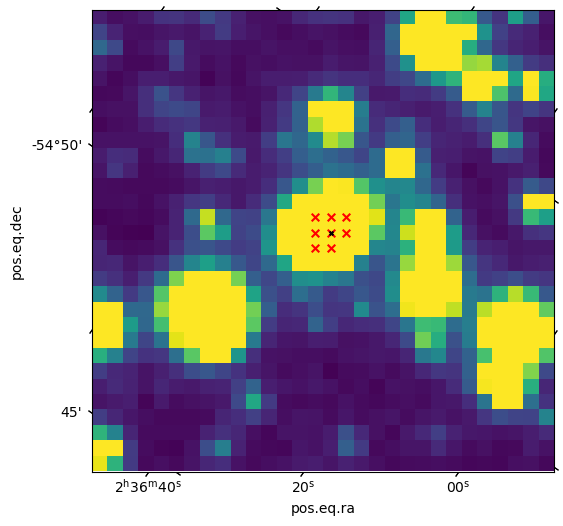

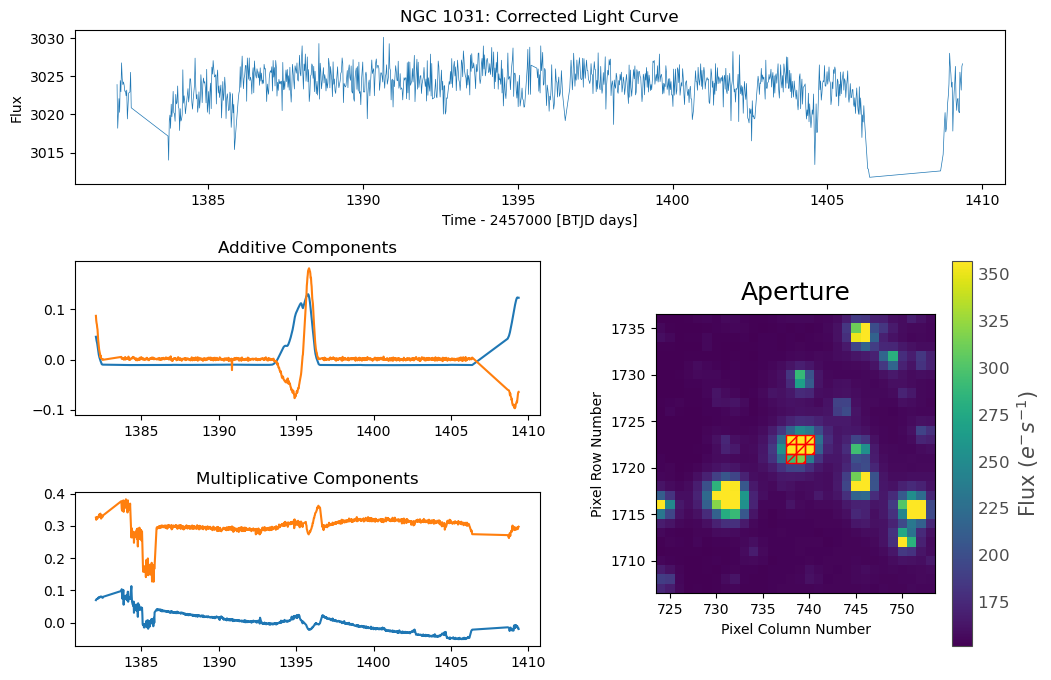

Sector, CCD, camera: 
3 2 3


Over- and underfitting metrics: 
Full hybrid overfit: 0.6667606750080698
Simple hybrid overfit: 0.8149368252818894
Simple PCA overfit: 0.6722742978762545


KeyError: 2

In [8]:
print('starting analysis')

#If object is observed by TESS and specified Cycle makes sense, begin aperture selection and extraction!
unstitched_lc_pca = []
unstitched_lc_simple_hyb = []
unstitched_lc_full_hyb = []

#vvv
#to save printed outputs to a file
"""original_stdout = sys.stdout
sys.stdout = StringIO()  # Redirect to a variable
tee_output = sys.stdout #"""
#^^^

for i in range(0,len(list_sectordata_index_in_cycle)):
    try:
        tpf = sector_data[list_sectordata_index_in_cycle[i]].download(cutout_size=(tpf_width_height, tpf_width_height)) #gets earliest sector
        integrated_flux = np.sum(tpf.flux.value, axis=0)
        #print(integrated_flux)
        #input('ok')
        tpf_orig = tpf
        sector_number = tpf.get_header()['SECTOR']
        sec = str(sector_number)
        ccd = tpf.get_header()['CCD']
        cam = tpf.get_header()['CAMERA']
        print("Generating pixel map for sector "+sec+".\n")

        #Check that this object is actually on silicon and getting data (not always the case just because TESSCut says so).
        #By making a light curve from a dummy aperture of the middle 5x5 square and seeing if its mean flux is zero.
        aper_dummy = np.zeros(tpf[0].shape[1:], dtype=bool) #blank
        aper_dummy[int(tpf_width_height/2-3):int(tpf_width_height/2+3),int(tpf_width_height/2-3):int(tpf_width_height/2+3)] = True
        lc_dummy = tpf.to_lightcurve(aperture_mask=aper_dummy)

        if np.mean(lc_dummy.flux) == 0:
            print("This object is not actually on silicon.")
            sys.ext()
        else:
            hdu = tpf.get_header(ext=2)
            #Get WCS information and flux stats of the TPF image.
            tpf_wcs = WCS(tpf.get_header(ext=2))
            pixmin = np.min(tpf.flux[plot_index]).value
    #vvv
            length = len(tpf.flux)
                #only when using pixmin instead of percentile for threshold:
            """plot_index_init = plot_index
            if pixmin <= 0:
                while plot_index < length - endlength:
                    plot_index += shift_plot_index
                    print('There are negative or zero flux values (pixmin =',pixmin_init,')! \nNow trying index',plot_index,'.')
                    pixmin = np.min(tpf.flux[plot_index]).value
                    if pixmin > 0:
                        break
                if pixmin <= 0:
                    pixmin = np.min(x for x in tpf.flux[plot_index_init] if x > 0).value
                    print('Could not find index without negative or zero flux values. Instead use smallest nonzero absolute value at index',plot_index_init,'. Resulting aperture might not be reasonable.')"""            
    #^^^
            pixmax = np.max(tpf.flux[plot_index]).value
            pixmean = np.mean(tpf.flux[plot_index]).value

            temp_min = float(pixmin)
            # print(temp_min)
            temp_max = float(1e-3*pixmax+pixmean)
            #temp_max = pixmax
            # print(temp_max)
            #Create a blank boolean array for the aperture, which will turn to TRUE when pixels are selected.
            aper = np.zeros(tpf[0].shape[1:], dtype=bool) #blank
            aper_mod = aper.copy() #For the source aperture
            aper_buffer = aper.copy()    #For the source aperture plus a buffer region to exclude from both additive and mult. regressors
            aper_width = tpf[0].shape[1]

        #vvv
            #threshold = pixmin * pixel_threshold
            integrated_flux = np.sum(tpf.flux.value, axis=0)
                #sometimes better to use tpf.flux[plot_index].value instead of background_flux?
            background_flux = np.percentile(tpf.flux[plot_index].value, background_percentile)
            int_background_flux = np.percentile(integrated_flux, background_percentile)
            threshold = background_flux * pixel_threshold
            int_threshold = int_background_flux * int_pixel_threshold
            row_col_coords_init = []
            """for y, row in enumerate(tpf.flux[plot_index].value):
                for x, pixel in enumerate(row):
                    if pixel > threshold:
                        row_col_coords.append((x, y))"""

            # Find the central pixel coordinates
            central = tpf_width_height // 2
            # Initialise visited matrix
            visited = [[False] * tpf_width_height for _ in range(tpf_width_height)]
            # Perform flood-fill starting from the central pixel
            #flood_fill(central, central, visited, row_col_coords_init, threshold, pixel_threshold)
            visited_new = [[False] * tpf_width_height for _ in range(tpf_width_height)]
            flood_fill_bridge(central, central, visited, row_col_coords_init, threshold, pixel_threshold, central)
            flood_fill_gaps(central, central, row_col_coords_init, visited_new)
            if len(row_col_coords_init) < 4:
                print("warning: aperture is only",len(row_col_coords_init),"pixels")
                """print('automatic aperture too small (',len(row_col_coords_init),'pixels), instead choose 4 pixel square')
                row_col_coords_init = []
                row_col_coords_init.append((central, central))
                row_col_coords_init.append((central - 1, central))
                row_col_coords_init.append((central, central - 1))
                row_col_coords_init.append((central - 1, central - 1))""" #not actually a problem
            
            #mirror pixels to account for original algorithm
            row_col_coords = [(y, x) for x, y in row_col_coords_init]
        #^^^

            """cid = fig.canvas.mpl_connect('button_press_event',onclick)
            plt.show()
            input("Press Enter to close the plot...")
            plt.close(fig)"""

            #Plot the TPF image and the DSS contours together, to help with aperture selection, along with the starter aperture.
            if lowest_dss_contour == 0.4:
                dss_levels = [0.4*dss_pixmax,0.5*dss_pixmax,0.75*dss_pixmax]
            elif lowest_dss_contour < 0.4:
                dss_levels = [lowest_dss_contour*dss_pixmax,0.4*dss_pixmax,0.5*dss_pixmax,0.75*dss_pixmax]
            elif lowest_dss_contour > 0.4:
                dss_levels = [lowest_dss_contour*dss_pixmax,0.65*dss_pixmax,0.85*dss_pixmax]
            fig = plt.figure(figsize=(6,6))
            ax = fig.add_subplot(111,projection=tpf_wcs)
            # ax.imshow(tpf.flux[200],vmin=pixmin,vmax=1e-3*pixmax+pixmean)
            ax.imshow(tpf.flux[plot_index].value,vmin=temp_min,vmax=temp_max)
            ax.contour(dss_image[0][0].data,transform=ax.get_transform(wcs_dss),levels=dss_levels,colors='white',alpha=0.9)
            for pixel in row_col_coords_init:
                ax.scatter(pixel[0], pixel[1], marker='x', color='red', s=30)
            ax.scatter(aper_width/2.0,aper_width/2.0,marker='x',color='k',s=8)
            ax.set_xlim(-0.5,aper_width-0.5)  #This section is needed to fix the stupid plotting issue in Python 3.
            ax.set_ylim(-0.5,aper_width-0.5)
            #plt.title('Define extraction pixels:')

#            fig.canvas.mpl_disconnect(cid)
            buffer_pixels = [] #Define the buffer pixel region.

            if len(row_col_coords) == 0:
                print('No mask selected; skipping this Sector.')
            else:
                for i in range(0,len(row_col_coords)):
                    aper_mod[row_col_coords[i]] = True
                    row_same_up_column = (row_col_coords[i][0],row_col_coords[i][1]+1)
                    row_same_down_column = (row_col_coords[i][0],row_col_coords[i][1]-1)
                    column_same_down_row = (row_col_coords[i][0]-1,row_col_coords[i][1])
                    column_same_up_row = (row_col_coords[i][0]+1,row_col_coords[i][1])
                    bottom_left_corner = (row_col_coords[i][0]-1,row_col_coords[i][1]-1)
                    top_right_corner = (row_col_coords[i][0]+1,row_col_coords[i][1]+1)
                    top_left_corner = (row_col_coords[i][0]+1,row_col_coords[i][1]-1)
                    bottom_right_corner = (row_col_coords[i][0]-1,row_col_coords[i][1]+1)
                    buffer_line = (row_same_up_column,row_same_down_column,column_same_up_row,column_same_down_row,top_left_corner,top_right_corner,bottom_left_corner,bottom_right_corner)
                    buffer_pixels.append(buffer_line)
                    for coord_set in buffer_line:
                            aper_buffer[coord_set[0],coord_set[1]]=True

                #Create a mask that finds all of the bright, source-containing regions of the TPF.
                allbright_mask = tpf.create_threshold_mask(threshold=bf_threshold,reference_pixel=None)
                allfaint_mask = ~allbright_mask
                allbright_mask &= ~aper_buffer
                allfaint_mask &= ~aper_buffer

                #Remove any empty flux arrays from the downloaded TPF before we even get started:
                boolean_orignans = []
                for i in range(0,length):
                    if np.sum(tpf.flux[i] == 0) or np.isnan(np.sum(tpf.flux[i])) == True:
                        nanflag = True
                    else:
                        nanflag = False
                    boolean_orignans.append(nanflag)
                boolean_orignans_array = np.array(boolean_orignans)
                tpf = tpf[~boolean_orignans_array]
        #vvv
                bkg_long_enough = True
                reached_end = False
                sys_threshold = sys_threshold_orig
                while bkg_long_enough:
                    number_masked_regions = 0
                    tpf = tpf_orig
                    print('\nstarting from scratch')
        #^^^
                    #Get the additive background first:
                    additive_hybrid_pcas = additive_pca_num
                    additive_bkg = DesignMatrix(tpf.flux[:, allfaint_mask]).pca(additive_hybrid_pcas)
                    additive_bkg_and_constant = additive_bkg.append_constant()
                    initial_bkg_length = len(additive_bkg.values)
                    print('initial bkg length:',initial_bkg_length)

                    #Add a module to catch possible major systematics that need to be masked out before continuuing:
                    if np.max(np.abs(additive_bkg.values)) > sys_threshold:   #None of the normally extracted objects has additive components with absolute values over 0.2 ish.
                        #redo_with_mask = input('Additive trends in the background indicate major systematics; add a cadence mask (Y/N)? ')
                        redo_with_mask = 'y' #automatically mask out systematics
                        if redo_with_mask == 'Y' or redo_with_mask=='y' or redo_with_mask=='YES' or redo_with_mask=='yes':
                            """fig_cm = plt.figure()
                            ax_cm = fig_cm.add_subplot()
                            ax_cm.plot(additive_bkg.values)
                            plt.title('Select first and last cadence to define mask region:')
                            cid_cm = fig_cm.canvas.mpl_connect('button_press_event',onclick_cm)
                            plt.show()
                            input("Press Enter to close the plot...")
                            plt.close(fig_cm)"""

            #vvv
                            masked_cadence_limits = []
                            bkg_all = [[time[i] for time in additive_bkg.values] for i in range(additive_pca_num)]
                            masks = [maskout(bkg) for bkg in bkg_all]
                            print('masks:',masks)
                            maskbegs = [lst[0] for lst in masks if lst]
                            masked_cadence_limits = []

                            if len(maskbegs) > 0:
                                masked_cadence_limits.append(min(maskbegs))
                                intervals = sorted([interval for lst in masks if lst for interval in [lst[i:i+2] for i in range(0, len(lst), 2)]], key=lambda x: x[1])
                                maskend = intervals[0][1]
                                for i in range(1,additive_pca_num):
                                    if len(intervals) > i:
                                        if intervals[i][0] < maskend:
                                            maskend = intervals[i][1]
                                masked_cadence_limits.append(maskend)
                                print('first masked region:',masked_cadence_limits)
                                print('len(additive_bkg.values) =',len(additive_bkg.values))
#                            print(masked_cadence_limits)
                            #input('stop')
#                            np.savetxt('PCAs before mask.txt',bkg_all)
            #^^^
                            #if len(masked_cadence_limits) != 0:
                                if masked_cadence_limits[0] >= 0:
                                    first_timestamp = tpf.time[masked_cadence_limits[0]].value
                                else:
                                    first_timestamp = 0
                                if masked_cadence_limits[1] < len(tpf.time) -1:
                                    last_timestamp = tpf.time[masked_cadence_limits[1]].value
                                else:
                                    last_timestamp = tpf.time[-1].value
                                cadence_mask = ~((tpf.time.value >= first_timestamp) & (tpf.time.value <= last_timestamp))
                                tpf = tpf[cadence_mask]
                                additive_bkg = DesignMatrix(tpf.flux[:, allfaint_mask]).pca(additive_hybrid_pcas)
                                additive_bkg_and_constant = additive_bkg.append_constant()
#                                print(np.max(np.abs(additive_bkg.values)))
                            
                                """np.savetxt('NGC 1031 auto PCA.txt',additive_bkg.values)
                                with open('NGC 1031 auto PCA 3.txt', 'w') as file:
                                    file.write(additive_bkg.values[2])
                                input('stop')"""

                        #vvv
                                #for i in range(0,max_masked_regions):
                                number_masked_regions = 1 #set to 1 at first, for this mask.
                                while np.max(np.abs(additive_bkg.values)) > sys_threshold:
#                                    print(np.max(np.abs(additive_bkg.values)))
                                    """fig_cm = plt.figure()
                                    ax_cm = fig_cm.add_subplot()
                                    ax_cm.plot(additive_bkg.values)
                                    plt.title('Select first and last cadence to define mask region:')
                                    cid_cm = fig_cm.canvas.mpl_connect('button_press_event',onclick_cm)
                                    plt.show()
                                    input("Press Enter to close the plot...")
                                    plt.close(fig_cm)"""

                                    bkg_all = [[time[i] for time in additive_bkg.values] for i in range(additive_pca_num)]
                                    masks = [maskout(bkg) for bkg in bkg_all]
                                    input('stop')
                                    #print('masks:',masks)
                                    maskbegs = [lst[0] for lst in masks if lst]
                                    masked_cadence_limits = []
                                    if len(maskbegs) > 0:
                                        number_masked_regions += 1
#                                        print('Systematics remain; define the next masked region.')
                                        masked_cadence_limits.append(min(maskbegs))
                                        intervals = sorted([interval for lst in masks if lst for interval in [lst[i:i+2] for i in range(0, len(lst), 2)]], key=lambda x: x[1])
                                        maskend = intervals[0][1]
                                        for i in range(1,additive_pca_num):
                                            if len(intervals) > i:
                                                if intervals[i][0] < maskend:
                                                    maskend = intervals[i][1]
                                        masked_cadence_limits.append(maskend)
                        #^^^
                                        if masked_cadence_limits[0] >= 0:
                                            first_timestamp = tpf.time[masked_cadence_limits[0]].value
                                        else:
                                            first_timestamp = 0
                                        if masked_cadence_limits[1] < len(tpf.time) -1:
                                            last_timestamp = tpf.time[masked_cadence_limits[1]].value
                                        else:
                                            last_timestamp = tpf.time[-1].value
                                        cadence_mask = ~((tpf.time.value >= first_timestamp) & (tpf.time.value <= last_timestamp))
                                        tpf = tpf[cadence_mask]
                                        additive_bkg = DesignMatrix(tpf.flux[:, allfaint_mask]).pca(additive_hybrid_pcas)
        #vvv
                                        if len(additive_bkg.values) < initial_bkg_length * min_bkg_length or number_masked_regions == max_masked_regions:
                                            sys_threshold += increase_sys_threshold
                                            if number_masked_regions == max_masked_regions:
                                                print('reached limit of', number_masked_regions, 'masks')
                                            else:
                                                print('too many masks, additive_bkg is too short')
                                            print('start again, new sys_threshold =',sys_threshold)
                                            bkg_long_enough = False
                                            break

                                        additive_bkg_and_constant = additive_bkg.append_constant()
                                        print('masked out',masked_cadence_limits)
                                        print('len(additive_bkg.values) =',len(additive_bkg.values),'/',initial_bkg_length)
                                    else:
                                        reached_end = True
                                        break
                                        #number_masked_regions = max_masked_regions+10    #stops the loop if the user no longer wishes to add more regions.
                                else:
                                    if np.max(np.abs(additive_bkg.values)) < sys_threshold:
                                        print('no more systematics above', sys_threshold, ', max:', np.max(np.abs(additive_bkg.values)))
                                    elif reached_end == True:
                                        print('Reached end of first mask iteration')
                                    else:
                                        print('Loop stopped without any condition being satisfied (?)')

                                if bkg_long_enough == False:
                                    bkg_long_enough = True
                                    continue
                            #else:
                             #   print('(?) loop stopped: sys_threshold =',sys_threshold,', max =',np.max(np.abs(additive_bkg.values)),', masks =',masks)
                    bkg_long_enough = False
                    print('no systematics, done with this sector')
                    print('max systematics:',np.max(np.abs(additive_bkg.values)))
                    print('masked out',number_masked_regions,'regions and',initial_bkg_length-len(additive_bkg.values),'of',initial_bkg_length,'timesteps \n')
#                input('stop')        
        #^^^

                # Now we correct all the bright pixels EXCLUDING THE SOURCE by the background, so we can find the remaining multiplicative trend
                r = RegressionCorrector(LightCurve(time=tpf.time, flux=tpf.time.value*0))
                corrected_pixels = []
                for idx in range(allbright_mask.sum()):
                    r.lc.flux = tpf.flux[:, allbright_mask][:, idx].value
                    r.lc.flux_err = tpf.flux_err[:, allbright_mask][:, idx].value
                    r.correct(additive_bkg_and_constant, propagate_errors=prop_error_flag)
                    corrected_pixels.append(r.corrected_lc.flux)

                #Getting the multiplicative effects now from the bright pixels.
                multiplicative_hybrid_pcas = multiplicative_pca_num
                multiplicative_bkg = DesignMatrix(np.asarray(corrected_pixels).T).pca(multiplicative_hybrid_pcas)
                
                #Create a design matrix using only the multiplicative components determined from the additively-corrected bright sources for simple hybrid method:
                dm_mult = multiplicative_bkg
                dm_mult = dm_mult.append_constant()
                #Now get the raw light curve.
                lc = tpf.to_lightcurve(aperture_mask=aper_mod)
            #  lc = lc[lc.flux_err > 0]        #This was suggested by an error message to prevent the "flux uncertainties" problem.
                median_flux_precorr = np.median(lc.flux.value) #Calculate the median flux before the background subtraction upcoming.

                #Begin the SIMPLE HYBRID METHOD
                #First, simple background subtraction to handle additive effects:
                lc_bg = tpf.to_lightcurve(method='sap',corrector=None,aperture_mask = allfaint_mask)
                num_pixels_faint = np.count_nonzero(allfaint_mask)
                num_pixels_mask = np.count_nonzero(aper_mod)
                percent_of_bg_in_src = num_pixels_mask / num_pixels_faint
                lc_bg_time = lc_bg.time.value
                lc_bg_flux = lc_bg.flux.value
                lc_bg_fluxerr = lc_bg.flux_err.value
                lc_bg_scaled = lc_bg_flux - (1-percent_of_bg_in_src)*lc_bg_flux
                lc.flux = lc.flux.value - lc_bg_scaled

                #Replace any errors that are zero or negative with the mean error:
                mean_error = np.mean(lc.flux_err[np.isfinite(lc.flux_err)])
                lc.flux_err = np.where(lc.flux_err == 0,mean_error,lc.flux_err)
                lc.flux_err = np.where(lc.flux_err < 0,mean_error,lc.flux_err)
                lc.flux_err = lc.flux_err.value

                #And correct regressively for the multiplicative effects in the simple hybrid method:
                corrector_1 = RegressionCorrector(lc)
                clc = corrector_1.correct(dm_mult,propagate_errors=prop_error_flag)

                #Compute over- and under-fitting metrics using Lightkurve's lombscargle and neighbors methods:
                corrector_1.original_lc = corrector_1.lc
                sh_overfit_metric = corrector_1.compute_overfit_metric()
                #sh_underfit_metric = corrector_1.compute_underfit_metric() #Has to wait until we make our own using quaver-derived light curves of nearby targets.

                #The background subtraction can sometimes cause fluxes below the source's median
                #to be slightly negative; this enforces a minimum of zero, but can be ignored.
                if np.min(clc.flux.value) < 0:
                    dist_to_zero = np.abs(np.min(clc.flux.value))
                    clc.flux = clc.flux.value + dist_to_zero

                # Optional additive correction back to original median:
                median_flux_postsub = np.median(clc.flux.value)
                additive_rescale_factor = median_flux_precorr - median_flux_postsub
                #clc.flux = clc.flux.value + additive_rescale_factor    #uncomment if you want to use this.
                var_amplitude = np.max(clc.flux.value) - np.min(clc.flux.value)
                percent_variability = (var_amplitude / median_flux_precorr)*100

                #For the FULL HYBRID METHOD:
                #We make a fancy hybrid design matrix collection that has two orders of the additive effects, and the multiplicative effects.
                additive_bkg_squared = deepcopy(additive_bkg)
                additive_bkg_squared.df = additive_bkg_squared.df**2
                dmc = DesignMatrixCollection([additive_bkg_and_constant, additive_bkg_squared, multiplicative_bkg])
                lc_full = tpf.to_lightcurve(aperture_mask=aper_mod)
                r2 = RegressionCorrector(lc_full)
                r2.lc.flux = lc_full.flux.value
                r2.lc.flux_err = lc_full.flux_err.value
                clc_full = r2.correct(dmc,propagate_errors=prop_error_flag)

                #Compute over- and under-fitting metrics using Lightkurve's lombscargle and neighbors methods:
                r2.original_lc = r2.lc
                fh_overfit_metric = r2.compute_overfit_metric()
                #fh_underfit_metric = r2.compute_underfit_metric()  #Has to wait until we make our own using quaver-derived light curves of nearby targets.
                #clc_full = RegressionCorrector(lc_full).correct(dmc,propagate_errors=prop_error_flag)

                #Now we begin the SIMPLE PCA METHOD with components of all non-source pixels.
                raw_lc_OF = tpf.to_lightcurve(aperture_mask=aper_mod)
                #Replace any errors that are zero or negative with the mean error:
                raw_lc_OF.flux_err = np.where(raw_lc_OF.flux_err == 0,mean_error,raw_lc_OF.flux_err)
                raw_lc_OF.flux_err = np.where(raw_lc_OF.flux_err < 0,mean_error,raw_lc_OF.flux_err)
                raw_lc_OF.flux_err = np.where(np.isnan(raw_lc_OF.flux_err)==True,mean_error,raw_lc_OF.flux_err)
            #    raw_lc_OF = raw_lc_OF[raw_lc_OF.flux_err > 0]   #This was suggested by an error message to prevent the "flux uncertainties" problem.
                regressors_OF = tpf.flux[:,~aper_mod]
                number_of_pcas = pca_only_num
                dm_OF = DesignMatrix(regressors_OF,name='regressors')
                dm_pca_OF = dm_OF.pca(pca_only_num)
                dm_pca_OF = dm_pca_OF.append_constant()
                r3 = RegressionCorrector(raw_lc_OF)
                r3.lc.flux = raw_lc_OF.flux.value
                r3.lc.flux_err = raw_lc_OF.flux_err.value
                corrected_lc_pca_OF = r3.correct(dm_pca_OF,propagate_errors=prop_error_flag)

                #Compute over- and under-fitting metrics using Lightkurve's lombscargle and neighbors methods:
                r3.original_lc = r3.lc
                pca_overfit_metric = r3.compute_overfit_metric()
                #pca_underfit_metric = r3.compute_underfit_metric()  #Has to wait until we make our own using quaver-derived light curves of nearby targets.

                #AND PLOT THE CORRECTED LIGHT CURVE.
                fig2 = plt.figure(figsize=(12,8))
                gs = gridspec.GridSpec(ncols=3, nrows=3,wspace=0.5,hspace=0.5,width_ratios=[1,1,2])
                f_ax1 = fig2.add_subplot(gs[0, :])
                f_ax1.set_title(target+': Corrected Light Curve')
                f_ax2 = fig2.add_subplot(gs[1, :-1])
                if primary_correction_method == 1:
                    f_ax2.set_title('Principal Components')
                    f_ax4 = fig2.add_subplot(gs[1:,-1])
                elif primary_correction_method == 2 or primary_correction_method == 3:
                    f_ax2.set_title('Additive Components')
                    f_ax3 = fig2.add_subplot(gs[2:,:-1])
                    f_ax3.set_title('Multiplicative Components')
                    f_ax4 = fig2.add_subplot(gs[1:,-1])

                if primary_correction_method == 1:
                    corrected_lc_pca_OF.plot(ax=f_ax1)
                elif primary_correction_method == 2:
                    clc.plot(ax=f_ax1)
                elif primary_correction_method == 3:
                    clc_full.plot(ax=f_ax1)
                if primary_correction_method == 1:
                    f_ax2.plot(raw_lc_OF.time.value,dm_pca_OF.values[:,0:-1])
                elif primary_correction_method == 2 or primary_correction_method == 3:
                    f_ax2.plot(raw_lc_OF.time.value,additive_bkg.values)
                    f_ax3.plot(raw_lc_OF.time.value,multiplicative_bkg.values + np.arange(multiplicative_bkg.values.shape[1]) * 0.3)
                tpf.plot(ax=f_ax4,aperture_mask=aper_mod,title='Aperture')

                    ## This section creates individual directories for each object in which the Quaver-processed light curve data is stored
                    ## and saves the output images and light curves to that directory. The output files WILL be overwritten with each Quaver run.
                directory = str(target).replace(" ","")
                target_safename = target.replace(" ","")
                try:
                    os.makedirs('quaver_output/'+target_safename)
                    print("Directory '% s' created\n" % directory)
                    if primary_correction_method == 1:
                        plt.savefig('quaver_output/'+target_safename+'/'+target_safename+'_SimplePCA_sector'+sec+'.pdf',format='pdf')
                        plt.show()
                    elif primary_correction_method == 2:
                        plt.savefig('quaver_output/'+target_safename+'/'+target_safename+'_SimpleHybrid_sector'+sec+'.pdf',format='pdf')
                        plt.show()
                    elif primary_correction_method == 3:
                        plt.savefig('quaver_output/'+target_safename+'/'+target_safename+'_FullHybrid_sector'+sec+'.pdf',format='pdf')
                        plt.show()
                except FileExistsError:
                    print("Saving to folder '% s'\n" % directory)
                    if primary_correction_method == 1:
                        plt.savefig('quaver_output/'+target_safename+'/'+target_safename+'_SimplePCA_sector'+sec+'.pdf',format='pdf')
                        plt.show()
                    elif primary_correction_method == 2:
                        plt.savefig('quaver_output/'+target_safename+'/'+target_safename+'_SimpleHybrid_sector'+sec+'.pdf',format='pdf')
                        plt.show()
                    elif primary_correction_method == 3:
                        plt.savefig('quaver_output/'+target_safename+'/'+target_safename+'_FullHybrid_sector'+sec+'.pdf',format='pdf')
                        plt.show()

                #Create saveable formats for the light curves and save to directory:
                pca_corrected_lc = np.column_stack((corrected_lc_pca_OF.time.value,corrected_lc_pca_OF.flux.value,corrected_lc_pca_OF.flux_err.value))
                simple_hybrid_corrected_lc = np.column_stack((clc.time.value,clc.flux.value,clc.flux_err.value))
                full_hybrid_corrected_lc = np.column_stack((clc_full.time.value,clc_full.flux.value,clc_full.flux_err.value))
                unstitched_lc_pca.append(pca_corrected_lc)
                unstitched_lc_simple_hyb.append(simple_hybrid_corrected_lc)
                unstitched_lc_full_hyb.append(full_hybrid_corrected_lc)
                np.savetxt('quaver_output/'+target_safename+'/'+target_safename+'_cycle'+str(cycle)+'_sector'+sec+'_PCA_lc.dat',pca_corrected_lc)
                np.savetxt('quaver_output/'+target_safename+'/'+target_safename+'_cycle'+str(cycle)+'_sector'+sec+'_simple_hybrid_lc.dat',simple_hybrid_corrected_lc)
                np.savetxt('quaver_output/'+target_safename+'/'+target_safename+'_cycle'+str(cycle)+'_sector'+sec+'_full_hybrid_lc.dat',full_hybrid_corrected_lc)

                print("Sector, CCD, camera: ")
                print(sector_number,ccd,cam)
                print('\n')
                print("Over- and underfitting metrics: ")
                print('Full hybrid overfit: '+str(fh_overfit_metric))
                #print('Full hybrid underfit: '+str(fh_underfit_metric)+'\n')
                print('Simple hybrid overfit: '+str(sh_overfit_metric))
                #print('Simple hybrid underfit: '+str(sh_underfit_metric)+'\n')
                print('Simple PCA overfit: '+str(pca_overfit_metric))
                #print('Simple PCA underfit: '+str(pca_underfit_metric)+'\n')

                #Plot the resultant fit (matrices multiplied by the final coefficients) for each model with the original and final curves.
                sh_coeffs = corrector_1.coefficients
                fh_coeffs = r2.coefficients
                pca_coeffs = r3.coefficients

                #Compute Simple Hybrid total model:
                total_fit_sh = sh_coeffs[0]*corrector_1.dmc.matrices[0][0]+sh_coeffs[1]*corrector_1.dmc.matrices[0][1]+sh_coeffs[2]*corrector_1.dmc.matrices[0][2]+sh_coeffs[3]
                #Compute Full Hybrid total model:
                first_set = fh_coeffs[0]*r2.dmc.matrices[0][0] + fh_coeffs[1]*r2.dmc.matrices[0][1] + fh_coeffs[2]*r2.dmc.matrices[0][2] +fh_coeffs[3]
                second_set = fh_coeffs[4]*r2.dmc.matrices[1][0] + fh_coeffs[5]*r2.dmc.matrices[1][1] + fh_coeffs[6]*r2.dmc.matrices[1][2]
                third_set = fh_coeffs[7]*r2.dmc.matrices[2][0] + fh_coeffs[8]*r2.dmc.matrices[2][1] + fh_coeffs[9]*r2.dmc.matrices[2][2]
                total_fit_fh = first_set+second_set+third_set
                #Compute PCA total model:
                total_fit_pca = pca_coeffs[0]*r3.dmc.matrices[0][0]+pca_coeffs[1]*r3.dmc.matrices[0][1]+pca_coeffs[2]*r3.dmc.matrices[0][2]+pca_coeffs[3]

                #Plot the FH diagnostic:
                clc_full.plot(color='k',label='Corrected')
                plt.plot(lc.time.value,lc_full.flux.value,color='firebrick',label='Uncorrected')
                plt.plot(lc.time.value,total_fit_fh,color='cyan',label='Final Model')
                plt.legend()
                plt.savefig('quaver_output/'+target_safename+'/'+target_safename+'_FitDiagnostic_sector_'+sec+'full_hybrid.pdf',format='pdf')
                plt.close()

                #Plot the SH diagnostic:
                plot_scale_factor = np.median(lc_full.flux.value) - np.median(lc_bg_scaled)
                if plot_scale_factor > 0:
                    lc_bg_plot = lc_bg_scaled + plot_scale_factor
                else:
                    lc_bg_plot = lc_bg_scaled - plot_scale_factor
                _, axs = plt.subplots(2, figsize=(10, 6), sharex=True)
                ax = axs[0]
                lc_full.plot(ax=ax,color='firebrick',label='Uncorrected')
                ax.plot(lc.time.value,lc_bg_plot,color='magenta',label='Subtracted Background')
                ax.legend()
                ax = axs[1]
                clc.plot(ax=ax,color='k',label='Corrected')
                ax.plot(lc.time.value,total_fit_sh,color='cyan',label='Multiplicative Model')
                ax.legend()
                plt.savefig('quaver_output/'+target_safename+'/'+target_safename+'_FitDiagnostic_sector_'+sec+'simple_hybrid.pdf',format='pdf')
                plt.close()

                #Plot the PCA diagnostic:
                corrected_lc_pca_OF.plot(color='k',label='Corrected')
                plt.plot(lc.time.value,raw_lc_OF.flux.value,color='firebrick',label='Uncorrected')
                plt.plot(lc.time.value,total_fit_pca,color='cyan',label='Final Model')
                plt.legend()
                plt.savefig('quaver_output/'+target_safename+'/'+target_safename+'_FitDiagnostic_sector_'+sec+'_PCA.pdf',format='pdf')
                plt.close()
                print("\nMoving to next sector.\n")
        #vvv
                """with open('quaver_output/'+target_safename+'/info_sector_'+sec+'.txt', 'w') as f:
                    sys.stdout = f  # Redirect to a file
                    print(tee_output.getvalue())
                sys.stdout = original_stdout
                print(tee_output.getvalue()) #"""
        #^^^
    # If target coordinates are too close to edge on approach, this will skip that sector and read the next.
    # If target coordinates are too close to edge on exit, this will skip that sector.
    ## WARNING: May also occur if connection to HEASARC could not be made. Check website and/or internet connection.
    except (http.client.IncompleteRead):
        print("Unable to download FFI cutout. Desired target coordinates may be too near the edge of the FFI.\n")
        print("Could be inability to connect to HEASARC. Check website availability and/or internet connection.\n")
        if i != num_obs_sectors-1:
            print("\nMoving to next sector.\n")
        continue
print('done')

In [ ]:
SkyView.list_surveys() 

In [9]:
print(len(tpf.flux))

1077


ideas: 
-don't allow masks of times already evaluated (only iterate once)
    -only allow twice
-fluid sys threshold (check)
-take analysis from elk
-enforce minimum aperture size, e.g. 4 px (check)
-try to reduce number of masks by combining adjacent ones (problem: don't know next mask beforehand) (check)
    overmasking removes data!
-define aperture based on DSS contours

write algo to reject long 1 px wide extensions in aperture
Remove minimum aperture (check)
Ensure aperture is not near edge
Try singular matrix error for other methods

problems:
aperture is rotated (solved)
NGC 4449 causes LinAlgError: Singular matrix (close to edge), so does NGC 821 sometimes
NGC 1574 causes IndexError: list index out of range (only for DSS, solved with TESS survey)
ESO 114-14 causes IndexError: index 30 is out of bounds for axis 0 with size 30 (all pixels in aperture) (as solved as possible)

new:
ask again about Singular Matrix error
why does checking for indices with 0 or nan flux take so long
ask about 2 PCA params error
"reduce with 1 or few principal components (will get rid of biggest systematic) with no mask, run again, see if anything is left above ~0.15 and mask it more carefully" does this mean retaining the tpf after the first reduction?
integrated flux sometimes (at smaller cadences?) gives very different apertures (possibly due to significant background systematics at some indices)
ask about new papers (pipeline comparison & Fausnaugh)

increase tpf size for large apertures
dss error exception

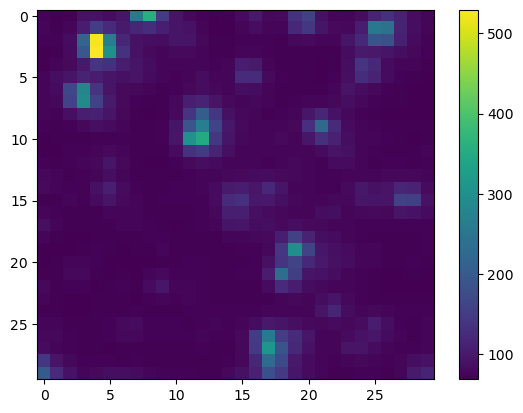

In [20]:
plt.imshow(tpf.flux[plot_index].value, cmap='viridis', aspect='auto')
plt.colorbar()
plt.show()

In [38]:
print(row_col_coords)
row_col_coords_mirrored = [(y, x) for x, y in row_col_coords]
print(row_col_coords_mirrored)
aper2 = np.zeros(tpf[0].shape[1:], dtype=bool)
aper3 = aper2.copy()
for i in range(0,len(row_col_coords)):
    aper3[row_col_coords[i]] = True
aper4 = []
for i, row in enumerate(aper3):
    for j, value in enumerate(row):
        if value:  # Check if the value is True
            aper4.append((j, i))
print(aper4)
#print(aper3)

[(15, 15), (16, 15), (17, 15), (18, 15), (19, 15), (20, 15), (20, 16), (21, 16), (21, 17), (20, 17), (19, 17), (18, 17), (17, 17), (16, 17), (15, 17), (14, 17), (13, 17), (12, 17), (11, 17), (10, 17), (10, 18), (11, 18), (10, 16), (11, 16), (13, 16), (14, 16), (15, 16), (16, 16), (17, 16), (18, 16), (19, 16), (14, 15), (13, 15), (14, 14), (15, 14), (16, 14), (17, 14), (18, 14), (19, 14), (17, 13), (16, 13), (15, 13), (14, 18), (15, 18), (16, 18), (17, 18), (18, 18), (19, 18), (20, 18), (20, 19), (19, 19), (18, 19), (17, 19), (16, 19), (18, 20), (19, 20)]
[(15, 15), (15, 16), (15, 17), (15, 18), (15, 19), (15, 20), (16, 20), (16, 21), (17, 21), (17, 20), (17, 19), (17, 18), (17, 17), (17, 16), (17, 15), (17, 14), (17, 13), (17, 12), (17, 11), (17, 10), (18, 10), (18, 11), (16, 10), (16, 11), (16, 13), (16, 14), (16, 15), (16, 16), (16, 17), (16, 18), (16, 19), (15, 14), (15, 13), (14, 14), (14, 15), (14, 16), (14, 17), (14, 18), (14, 19), (13, 17), (13, 16), (13, 15), (18, 14), (18, 15)

In [27]:
print(row_col_coords)

aper_mod_aper = []
for i, row in enumerate(aper_mod):
    for j, value in enumerate(row):
        if value:  # Check if the value is True
            aper_mod_aper.append((j, i))
print(aper_mod_aper)

aper_buffer_aper = []
for i, row in enumerate(aper_buffer):
    for j, value in enumerate(row):
        if value:  # Check if the value is True
            aper_buffer_aper.append((j, i))
print(aper_buffer_aper)

print(len(row_col_coords))
print(len(aper_mod_aper))
print(len(aper_buffer_aper))

[(15, 15), (16, 15), (17, 15), (18, 15), (19, 15), (20, 15), (20, 16), (21, 16), (21, 17), (20, 17), (19, 17), (18, 17), (17, 17), (16, 17), (15, 17), (14, 17), (13, 17), (12, 17), (11, 17), (10, 17), (10, 18), (11, 18), (10, 16), (11, 16), (13, 16), (14, 16), (15, 16), (16, 16), (17, 16), (18, 16), (19, 16), (14, 15), (13, 15), (14, 14), (15, 14), (16, 14), (17, 14), (18, 14), (19, 14), (17, 13), (16, 13), (15, 13), (14, 18), (15, 18), (16, 18), (17, 18), (18, 18), (19, 18), (20, 18), (20, 19), (19, 19), (18, 19), (17, 19), (16, 19), (18, 20), (19, 20)]
[(16, 10), (17, 10), (18, 10), (16, 11), (17, 11), (18, 11), (17, 12), (15, 13), (16, 13), (17, 13), (14, 14), (15, 14), (16, 14), (17, 14), (18, 14), (13, 15), (14, 15), (15, 15), (16, 15), (17, 15), (18, 15), (13, 16), (14, 16), (15, 16), (16, 16), (17, 16), (18, 16), (19, 16), (13, 17), (14, 17), (15, 17), (16, 17), (17, 17), (18, 17), (19, 17), (14, 18), (15, 18), (16, 18), (17, 18), (18, 18), (19, 18), (20, 18), (14, 19), (15, 19)

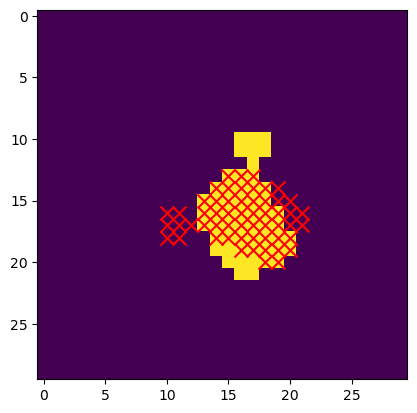

In [32]:
grid_size = 30
grid = [[False] * grid_size for _ in range(grid_size)]
for x, y in row_col_coords:
    grid[x][y] = True
grid_int = [[int(value) for value in row] for row in grid]
plt.imshow(grid_int, cmap='viridis', interpolation='nearest')
plt.scatter(*zip(*row_col_coords), color='red', marker='x', s=100, label='True Indices')

aper_mod_int = np.array(aper_mod, dtype=int)
plt.imshow(aper_mod_int, cmap='viridis', interpolation='nearest')
plt.show()

In [46]:
np.savetxt('NGC 1031 auto PCA.txt',additive_bkg.values)

No more observed sectors in this cycle.
Stitching 4 sectors


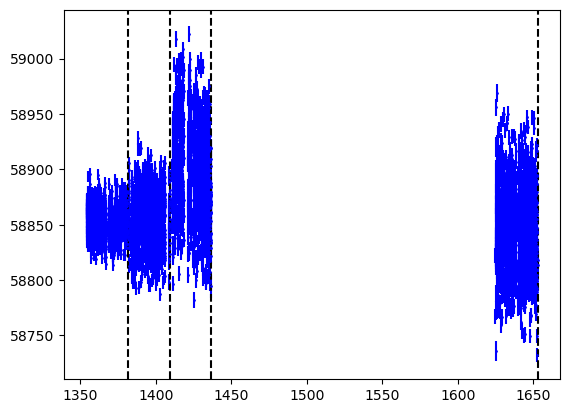

Done!


In [20]:
#Stitch the sectors together:
print("No more observed sectors in this cycle.")
if len(unstitched_lc_simple_hyb)==0 and len(unstitched_lc_pca)==0 and len(unstitched_lc_full_hyb)==0:
    print("No light curve data extracted, exiting program.")
    sys.exit()
else:
    print('Stitching '+str(len(list_observed_sectors_in_cycle))+' sectors')
full_lc_time_pca,full_lc_flux_pca,full_lc_err_pca = lc_stitch(unstitched_lc_pca)
full_lc_time_sh,full_lc_flux_sh,full_lc_err_sh = lc_stitch(unstitched_lc_simple_hyb)
full_lc_time_fh,full_lc_flux_fh,full_lc_err_fh = lc_stitch(unstitched_lc_full_hyb)

#Remove single-cadence jumps greater than 1% of the flux on either side from all finished light curves
full_lc_time_pca,full_lc_flux_pca,full_lc_err_pca = remove_jumps(full_lc_time_pca,full_lc_flux_pca,full_lc_err_pca)
full_lc_time_sh,full_lc_flux_sh,full_lc_err_sh = remove_jumps(full_lc_time_sh,full_lc_flux_sh,full_lc_err_sh)
full_lc_time_fh,full_lc_flux_fh,full_lc_err_fh = remove_jumps(full_lc_time_fh,full_lc_flux_fh,full_lc_err_fh)

#Compile and save the corrected light curves.
pca_lc = np.column_stack((full_lc_time_pca,full_lc_flux_pca,full_lc_err_pca))
simple_hybrid_lc = np.column_stack((full_lc_time_sh,full_lc_flux_sh,full_lc_err_sh))
full_hybrid_lc = np.column_stack((full_lc_time_fh,full_lc_flux_fh,full_lc_err_fh))

np.savetxt('quaver_output/'+target_safename+'/'+target_safename+'_cycle'+str(cycle)+'_PCA_lc.dat',pca_lc)
np.savetxt('quaver_output/'+target_safename+'/'+target_safename+'_cycle'+str(cycle)+'_simple_hybrid_lc.dat',simple_hybrid_lc)
np.savetxt('quaver_output/'+target_safename+'/'+target_safename+'_cycle'+str(cycle)+'_full_hybrid_lc.dat',full_hybrid_lc)

#Plot the corrected light curves and save images.
fig_pca = plt.figure()
plt.errorbar(full_lc_time_pca,full_lc_flux_pca,yerr = full_lc_err_pca,marker='o',markersize=1,color='b',linestyle='none')
for i in range(0,len(unstitched_lc_pca)):
    last_time = unstitched_lc_pca[i][:,0][-1]
    plt.axvline(x=last_time,color='k',linestyle='--')
plt.savefig('quaver_output/'+target_safename+'/'+target_safename+'_cycle'+str(cycle)+'_stitched_lc_pca.pdf',format='pdf')
if primary_correction_method == 1:
        plt.show()
plt.close(fig_pca)

fig_sh = plt.figure()
plt.errorbar(full_lc_time_sh,full_lc_flux_sh,yerr = full_lc_err_sh,marker='o',markersize=1,color='b',linestyle='none')
for i in range(0,len(unstitched_lc_simple_hyb)):
    last_time = unstitched_lc_simple_hyb[i][:,0][-1]
    plt.axvline(x=last_time,color='k',linestyle='--')
plt.savefig('quaver_output/'+target_safename+'/'+target_safename+'_cycle'+str(cycle)+'_stitched_lc_simple_hybrid.pdf',format='pdf')
if primary_correction_method == 2:
    plt.show()
plt.close(fig_sh)

fig_fh = plt.figure()
plt.errorbar(full_lc_time_fh,full_lc_flux_fh,yerr = full_lc_err_fh,marker='o',markersize=1,color='b',linestyle='none')
for i in range(0,len(unstitched_lc_full_hyb)):
    last_time = unstitched_lc_full_hyb[i][:,0][-1]
    plt.axvline(x=last_time,color='k',linestyle='--')
plt.savefig('quaver_output/'+target_safename+'/'+target_safename+'_cycle'+str(cycle)+'_stitched_lc_full_hybrid.pdf',format='pdf')
if primary_correction_method == 3:
    plt.show()
plt.close(fig_fh)

print ("Done!")

In [22]:
print(additive_bkg)
print(additive_bkg.values[0][0])

unnamed_matrix DesignMatrix (1196, 3)
0.0032320037249671837


In [ ]:
# cells below: moved over from quaver final

for i in range(3):
    original_stdout = sys.stdout 
    sys.stdout = open('test'+str(i)+'.txt', 'w')
    print("i =",i)
    sys.stdout = original_stdout
print('end')

In [ ]:
original_stdout = sys.stdout 
sys.stdout = open('before_loop.txt', 'w')
print("This will be written to the 'before_loop.txt' file")
sys.stdout = original_stdout

# Loop through your data
for i in range(3):  # replace this with your actual loop
    original_stdout = sys.stdout 
    sys.stdout = open(f'output_{i}.txt', 'w')
    print(f"This is iteration {i}. This will be written to the 'output_{i}.txt' file")
    sys.stdout = original_stdout

print('a')

In [ ]:
import sys

# Save the text that gets printed before the loop starts
original_stdout = sys.stdout 
sys.stdout = open('before_loop.txt', 'w')
print("This will be written to the 'before_loop.txt' file")
sys.stdout.close()
sys.stdout = original_stdout

# Open the file and set the new stdout to the file
sys.stdout = open('output.txt', 'w')

# Loop through your data
for i in range(3):  # replace this with your actual loop
    print(f"This is iteration {i}. This will be written to the 'output_{i}.txt' file")

# Print statements after the loop
print("This will also be written to the 'output.txt' file")

# Reset stdout
sys.stdout.close()
sys.stdout = original_stdout

# This print statement will be printed to the console
print("This will be printed to the console")


In [ ]:
#NGC 1031 Sector 69
#problem: central pixel flux = 674, background 76 for plot_index
#    but central pixel flux = 10.8e7, background 5.0e7 for integrated flux -> pixel below threshold, aperture 1 pixel
flux = [[81.67626,80.88757,93.91317,112.63154,94.574104,80.78358,79.56104,79.490616,75.92792,77.68185,75.57466,75.261185,74.861275,74.17751,75.76248,78.011314,77.71213,77.36272,79.388855,84.684654,103.08218,111.912224,83.7659,78.197815,77.25125,74.74467,76.969376,77.83359,74.26205,75.058205],[78.64639,77.67804,82.42687,83.48544,79.98131,79.16614,78.335594,77.530266,76.20649,79.067665,79.44095,76.327995,74.58343,74.09092,74.27975,74.87226,76.34648,77.10403,79.29295,93.74436,176.99292,291.12347,115.30872,87.88162,80.44044,79.19903,77.75026,77.97089,76.057594,74.8829],[77.94063,77.05032,77.153076,77.019455,78.22543,77.50471,78.74656,76.75796,77.119896,77.02202,83.68972,77.580376,74.587654,75.29271,75.38885,76.275604,76.58074,74.244644,78.52319,90.217514,123.71995,176.37468,136.00476,132.86676,97.90818,82.78341,79.03551,76.86227,76.35143,75.83716],[78.50928,78.18462,77.37321,74.82011,77.39074,78.11214,78.2958,76.47493,76.43906,74.71079,76.55846,73.99387,75.743004,74.40454,74.90825,74.54911,75.23477,76.54599,78.60904,80.74215,93.44005,112.72106,172.77637,360.4233,209.69655,97.10917,81.84319,77.68636,76.47495,75.45117],[76.651886,79.0696,81.56936,76.26277,75.919205,76.41253,76.34868,76.91948,76.8845,76.820724,74.811714,74.32555,75.01573,75.19644,75.41246,77.84108,76.69466,81.5974,81.52676,79.406944,87.64939,113.021866,219.47098,854.3227,523.468,126.70754,86.37548,79.43447,76.59946,77.35234],[76.08499,79.347206,88.08264,79.06062,77.32314,77.776596,77.08661,74.773285,75.87045,76.62865,74.764496,76.81081,76.13997,74.848976,75.68689,75.60105,78.28169,88.5831,86.79455,78.01115,84.00062,102.09941,149.13385,238.64839,194.58493,115.2387,85.331215,80.0287,77.56767,75.49321],[77.94198,76.79157,79.19093,77.52412,78.4831,85.033554,81.238686,74.928154,76.22051,75.78656,74.44929,74.9153,77.08854,74.85096,76.81963,75.429665,79.1417,89.52612,94.77749,85.32921,80.41681,83.4565,92.60094,104.02108,101.01996,88.7795,80.807526,79.79172,77.84042,76.144684],[76.17977,78.01767,77.205025,75.751915,78.61776,85.54779,84.34246,75.898254,76.110916,76.42395,74.32899,76.1684,75.85549,75.81823,76.11746,77.97163,82.260574,89.71717,104.84089,117.638664,91.98074,83.19439,81.21361,82.385185,82.20222,79.7931,78.07527,77.26113,76.18524,75.71262],[76.73503,77.91326,77.92665,77.49216,78.57076,77.675865,80.96369,76.014656,75.267,76.72808,75.44765,76.142654,76.57815,77.19705,75.73633,78.6179,83.63097,100.63491,161.5038,290.80124,165.31992,90.4733,80.410034,77.394104,77.921326,76.65056,76.3776,76.21156,76.3629,76.235504],[78.55198,78.383095,77.33829,76.42013,80.32393,79.83605,79.23432,77.82442,76.23134,77.47536,76.61704,77.77135,78.71285,77.56753,81.956764,82.13973,81.88636,98.27386,153.13268,343.3895,267.88263,112.043594,83.854256,79.26749,76.55856,75.50513,75.05162,79.28166,79.438614,79.05044],[77.39856,77.907715,78.65712,84.84718,93.57054,97.222694,93.744606,84.810074,80.91246,76.52389,76.830215,80.19754,79.17566,76.93364,79.53869,81.405205,79.39261,86.290825,106.3266,136.86882,133.32953,99.513275,83.90562,78.3645,74.29458,75.35303,76.580376,84.60771,88.577065,77.94255],[76.26411,79.0587,82.67078,100.94942,145.53203,201.14471,148.70709,101.08185,86.20004,81.691925,80.22224,80.37397,79.351685,78.55944,79.06947,80.75296,79.18793,80.60167,86.965965,96.545296,115.778854,109.60718,83.39092,76.16769,76.36496,75.94074,77.66681,94.386406,117.90414,84.76645],[79.4079,81.15054,91.70974,130.17717,230.74338,561.4204,384.5981,140.78564,96.752785,87.44173,78.23236,81.76997,85.053955,87.120155,89.16229,87.73538,83.61838,82.104095,87.009,95.13885,172.8795,199.6851,92.84788,78.99322,75.26685,75.61323,75.59271,80.96214,82.58009,77.431465],[80.874466,83.16463,95.43985,156.49207,330.97498,1522.6593,1206.0593,225.68152,110.99529,87.17736,80.637344,84.17078,94.733406,114.50059,131.76694,120.15022,100.65613,89.78338,85.40243,91.161995,109.4321,119.03578,88.85207,79.94778,75.6858,74.374825,75.09121,76.878586,76.19523,75.66118],[84.71425,82.306755,89.275154,128.84196,230.18732,463.81805,429.13324,207.05692,112.038536,88.265366,83.32217,92.42536,118.578316,174.97337,275.72437,286.26358,164.20445,109.93418,91.98106,87.10731,85.86456,85.46432,81.73852,76.806435,74.75612,74.62586,75.25325,77.49574,76.03453,75.39192],[97.33621,82.56913,83.98718,93.26652,119.156654,145.74034,143.55502,114.85186,95.04123,83.19614,84.76905,96.24695,131.06827,227.0487,511.39026,673.5065,306.9213,147.15279,101.90013,87.06379,85.72304,83.50909,79.00789,77.96391,77.683716,76.09342,76.162186,82.438286,85.284195,76.90928],[97.377525,83.387955,81.42943,83.32374,87.52347,94.13404,92.37284,87.59179,81.09029,80.155304,79.38541,87.96943,110.08151,165.13489,262.42596,323.68433,221.6503,136.34357,99.46664,87.35611,90.38791,93.93951,78.933205,76.41449,76.835625,76.38756,75.89145,83.02003,86.942345,76.78171],[83.16622,82.45839,78.23286,78.85752,78.93086,82.97355,82.4898,84.62632,83.386284,77.46869,79.58939,80.67195,90.09949,103.90049,121.13942,129.89111,118.36882,99.89883,88.88194,86.27867,109.473694,144.41423,87.193405,78.15101,77.1274,75.84686,77.65473,80.6853,78.25422,77.324326],[78.65886,79.43542,77.38501,76.7176,77.37611,79.949684,82.24902,92.50055,95.20159,78.681114,79.8362,78.010605,79.971405,84.71826,86.36033,90.44719,87.39895,82.91162,81.180214,80.74149,87.13856,91.43355,84.202896,78.68103,77.35022,76.832214,78.4669,85.97641,86.99853,80.5538],[77.19398,77.54155,78.16864,75.20209,75.97269,79.0062,80.82432,86.8143,89.665504,78.256874,76.40947,76.66107,77.18028,78.18268,79.77419,81.370735,82.92617,82.89539,80.346886,77.77665,77.773544,79.877945,82.50701,78.41254,76.2888,78.26216,81.694084,109.17732,146.22908,93.96294],[78.818375,77.28963,75.46322,75.36038,75.219955,77.30888,78.50859,79.52969,78.813,76.87887,77.06053,75.22102,76.03867,75.85971,77.23753,84.897446,85.45992,91.841866,100.730286,81.47344,79.709785,78.370995,78.349045,76.905426,76.37525,78.30669,86.21153,115.43643,192.05046,111.250725],[77.38203,75.818474,77.03955,74.341415,74.77633,76.70574,77.360985,76.07576,75.66124,76.47847,79.9234,77.470604,74.96483,78.30571,82.55648,82.15019,84.31437,113.82922,186.78302,105.90876,82.643,78.15975,78.42387,78.74153,81.009605,86.45221,91.25785,92.53902,94.08367,86.0714],[77.59272,77.82422,76.9661,75.50438,76.23098,77.28472,76.561874,76.47479,77.10759,78.98539,82.91834,81.37038,74.953766,77.1751,79.972984,81.39449,85.54444,108.730286,198.66992,124.41202,84.04324,77.0664,77.39081,81.05393,87.45793,109.25045,143.22763,105.3406,89.22076,84.31072],[76.60733,76.46932,75.8039,74.19857,75.324005,76.57687,77.49238,76.391075,78.66825,91.61379,80.77552,75.99091,75.08161,75.61527,76.179085,78.64434,80.761734,84.73185,89.88361,84.57893,81.79828,77.5528,74.11458,80.04106,95.7583,172.9785,449.59714,199.98196,101.958916,103.52421],[76.46669,76.8507,76.13479,76.034355,78.31866,77.66521,76.99479,75.70217,78.040306,80.03046,80.30516,75.944435,76.16598,75.405785,77.3455,76.81973,77.70361,76.331764,79.824524,77.82256,76.66176,76.36899,76.29236,79.79902,98.284,142.98729,296.5601,190.48116,101.26434,89.32175],[74.071335,75.07368,77.457794,76.4104,77.28187,78.46158,75.96367,75.761925,76.15634,78.05187,77.21622,75.85814,76.23765,74.496124,75.83933,77.501625,75.84478,75.470245,76.547516,75.91406,76.46172,75.23599,73.441956,76.22105,81.86368,95.07374,109.32897,99.49882,84.15905,79.65443],[76.27267,77.199684,78.17756,75.65971,75.30215,75.354126,76.752304,74.86417,78.21612,80.4708,78.5093,75.61702,75.81356,75.96995,75.01616,75.98303,75.447754,74.57559,75.66974,75.72204,73.46572,75.91375,75.03947,75.92809,77.290504,80.5282,83.30437,81.49164,78.856224,76.94532],[76.73524,76.19146,77.40354,73.750015,75.24814,74.116806,76.53447,78.070854,80.46291,78.88352,76.45828,75.458954,74.88498,75.24918,74.03519,75.437096,75.0655,75.25515,76.24571,75.06015,74.87442,75.33838,77.17322,76.55041,76.09023,75.288666,77.06005,76.61455,75.981926,75.33569],[78.09292,77.85092,76.01207,75.30124,75.4606,74.75133,76.93496,76.13976,77.12996,77.32205,75.50243,76.872574,75.04875,75.02523,75.19803,76.31002,75.69158,75.553246,76.83091,78.45282,78.18032,80.34776,79.43879,83.53537,77.63174,77.21764,76.8464,76.15535,76.00706,75.11308],[77.61138,79.27624,76.44819,75.39564,75.47855,75.54005,75.91459,73.66421,77.05247,74.69792,78.90456,80.61149,75.68359,75.819405,76.76264,75.59142,77.1081,76.06838,75.58102,81.236244,95.00778,89.19397,93.68716,110.205574,85.788635,80.16973,79.72319,76.40135,75.9874,76.74369]]
intflux = [[5119784.5,5211987.5,5331779,5464553.5,5254352,5197282,5172850.5,5085978.5,5031924.5,5018716.5,5007996.5,5000346.5,4993494.5,4992569,5009909.5,5013391.5,5016513,5002411.5,5017297,5075281,5248408.5,5304684,5063452.5,5012917,4997332,4986660.5,4998387,5005331.5,4979306.5,4977907.5],[5101820.5,5178862,5210250.5,5147183,5114714,5181560.5,5165984.5,5086682.5,5033511.5,5025540.5,5043496,5008599.5,4996714.5,4992668,4991489.5,4997193,4999520,4993991.5,5037636.5,5152523,5972560,6999193.5,5352690.5,5092576.5,5036059.5,5013858.5,5004266,5002502,4991326,4982695.5],[5083367,5174297,5174179,5080156.5,5078148,5166260.5,5162536.5,5072661.5,5028477.5,5037746.5,5083754,5020102.5,4998641,4993241.5,4993621.5,4995599,5000669.5,4999979,5036545.5,5135459,5505777,6070339.5,5579501,5494239.5,5192616.5,5064244.5,5018088.5,4996177,4984985.5,4984622],[5096740,5171151,5167885,5077419,5070915,5162730,5167895.5,5070865.5,5032267.5,5023591.5,5014621,5000801.5,4997933.5,4993540.5,4995543,5001071.5,4999864.5,5006535.5,5016038,5056117.5,5169879.5,5359851,5892329.5,7500960.5,6171829.5,5197161.5,5051883.5,5009348.5,4990137.5,4986135.5],[5085030.5,5185558.5,5207315,5078297.5,5075607,5160550,5154291.5,5060107,5027831,5013876,5006669.5,5000360,5006140,4999782.5,4995904,4998643.5,5011175,5038298,5040231.5,5032366,5109401.5,5359983,6426088,12664946,9265895,5468548,5091471.5,5023510,4993254,4999695],[5087207.5,5195338.5,5255527.5,5104502,5088736.5,5171306,5160549.5,5060305.5,5024995.5,5019262,5011432,5001345.5,5003776.5,4998865.5,5001760,4999196,5027121,5110907,5096881,5026750,5061745.5,5254291.5,5755987.5,6778140,6295989,5400233.5,5097443,5025354,5008612.5,4994561.5],[5074198,5173846,5185363,5093652.5,5101783,5231924,5199230,5066717.5,5035180,5020960,5014523.5,5001650.5,4993752.5,5003387,5002945,5005558.5,5026625,5126639,5188681,5083663,5040262.5,5082948.5,5184970.5,5296021.5,5253904,5128865,5053582.5,5023170,5022337.5,5001291],[5089032,5175878.5,5168309.5,5081270.5,5105199.5,5257363,5240391.5,5078569.5,5067400.5,5039274.5,5023589.5,5001302.5,4999402,5007720,5011585.5,5017375,5049466,5130953,5274134,5368658.5,5143664.5,5058148,5059001,5068600,5052610,5029860.5,5016289,5008691,5002569,4993245.5],[5086332.5,5175345.5,5171039.5,5100896.5,5113279.5,5214081,5197890.5,5080415.5,5056029,5035801.5,5023248.5,5013372.5,5009328.5,5006998.5,5016183,5032726,5077278.5,5247773,5812720,6942287.5,5789147,5137427.5,5042565.5,5032174,5019917,5005434,4999297.5,5005296,5004965.5,5010544],[5096383,5178099,5179540,5101902.5,5107996.5,5215940,5196179.5,5093908,5055701.5,5044360,5027596.5,5045152,5038533.5,5018524,5062815,5070273,5068653.5,5236218.5,5801462,7691171,6885500,5339964,5074702,5032312,5008749,4993880.5,5001161,5022419.5,5022307.5,5021517.5],[5102821.5,5201241.5,5202166.5,5165107.5,5238792.5,5362158,5311527.5,5151401,5092891,5057479,5038697.5,5065113,5066460.5,5029266,5056960.5,5062880,5046209.5,5125804,5317072.5,5646095,5611571,5238244.5,5078335.5,5024673.5,5008930.5,5003350,5008110,5076202.5,5124191.5,5027062.5],[5094257,5200614,5233883,5319206,5735350.5,6280149.5,5829328.5,5314299,5149110,5099917,5054069.5,5045588.5,5056233.5,5042631.5,5049150.5,5040401,5039183,5055465,5124374,5206421.5,5384639,5314874,5079925,5022822.5,5005050.5,5006381,5020001,5181865.5,5406689.5,5075678.5],[5111442.5,5216374,5321041,5599153.5,6522029,9491328,7890455,5660783,5244099,5141451,5064129,5083866,5112886.5,5115989.5,5135807.5,5117964,5079282.5,5078299,5107888,5184999,5948131.5,6187643,5166378,5033512.5,5005852.5,4994892.5,5014266.5,5047506.5,5085737.5,5037728.5],[5128653.5,5230308,5362189,5862955.5,7588214,19277148,15863330,6461018,5353567.5,5157886.5,5087244,5109786.5,5198093,5365265,5516952,5411387.5,5238905.5,5127882.5,5105391,5148657,5372752.5,5481726.5,5153930,5035005.5,5008628.5,4990761,5006105,5009672.5,5009209.5,5000286.5],[5173378,5241378,5308238,5636328,6669659.5,9356268,8967787,6404964,5399838,5163888,5110631.5,5166929,5420106.5,5935527,6837068,6877843.5,5827162,5338928,5152786.5,5102189.5,5114199,5101361.5,5061512.5,5025892,5002520.5,4991242,5001561.5,5007714,5008978,5002032],[5278153.5,5232391,5247160,5265965.5,5535902.5,5918829,5882056.5,5474396,5230073.5,5138875.5,5115467.5,5211057,5558012,6504350,9278140,10764602,7176649.5,5684856.5,5259518,5121187.5,5094330.5,5072041.5,5038731.5,5025702,5007788.5,5001121.5,5007201.5,5071722,5080197.5,5016324],[5299398.5,5239461.5,5229112,5159143.5,5215157.5,5368308,5351123,5206082,5116070,5083229.5,5070659,5157113,5374662,5924410.5,6999009.5,7642086.5,6512773,5611526.5,5257145,5129308,5152399.5,5187218.5,5050355,5027371,5020814,5011311,5006701,5081135.5,5127347.5,5030671.5],[5175872.5,5218641.5,5201159.5,5110722,5124637,5249776,5251353.5,5158148,5105121,5058886,5056342.5,5071807,5154615,5306227.5,5502521.5,5577025,5447855,5257781,5145998.5,5106286,5326472,5648730,5123944,5026489.5,5013869,5010944.5,5020281.5,5035928,5038376,5030992.5],[5123081,5204143,5196980.5,5098694.5,5111380.5,5227822,5240433,5225270,5207500.5,5062318.5,5061681,5043666,5072910.5,5105879,5144727,5163078,5147834,5095780,5065299,5065296.5,5132553,5193773.5,5094589,5040495,5016411,5013067,5034125.5,5092504,5102229.5,5060414],[5113007.5,5188787.5,5187713.5,5096803.5,5099118,5199016.5,5208581,5188017,5176413.5,5054955,5032427.5,5026537,5032343.5,5037728,5054881,5072974,5086342.5,5079904.5,5061070,5035358.5,5037504.5,5054459.5,5067581.5,5032937.5,5018667,5027726,5062921.5,5309132,5624672,5171925.5],[5105171,5194394,5180838.5,5090322.5,5092852,5190293.5,5198115.5,5113304.5,5064232.5,5044283,5026632.5,5022455.5,5030090.5,5031739,5049592.5,5096225,5108176.5,5172166,5233022,5072160.5,5045466,5032406.5,5032963,5022804.5,5021387.5,5034443.5,5101248,5419392.5,6188454,5341661],[5104294,5198708,5194386,5086144.5,5089935.5,5189903,5182892,5083272,5050466.5,5050854,5059438,5036640,5032597.5,5041804.5,5075948,5089984,5121460.5,5385770,6015788.5,5290269,5076483,5029616.5,5025270,5031645,5055701.5,5117772,5158445,5192898,5215249.5,5129971.5],[5107581,5191709,5179812.5,5088362,5090736.5,5185026.5,5173439,5086475,5057026.5,5066706,5106092,5086924.5,5029988.5,5024661.5,5061772.5,5063752,5105878,5353946.5,6288199.5,5497275.5,5089689.5,5031679.5,5024328.5,5062869,5123861,5332775,5618846.5,5287238,5135887.5,5100428],[5105813.5,5187213.5,5184021.5,5094355.5,5097772.5,5175059,5174913,5083819.5,5074742,5171661,5072610.5,5038360,5021798,5024078,5024772.5,5038532.5,5068282.5,5125395,5178422.5,5114984,5059072.5,5031921.5,5030487,5081510,5201186,5957252,8481582,6128833.5,5243948.5,5255718.5],[5096782,5182354.5,5190275,5105485,5124559,5185295.5,5176270.5,5085745,5065042.5,5093764,5058714.5,5036065,5028522,5021765.5,5029750,5032038,5038378,5040304.5,5050705.5,5034384.5,5024929.5,5024578.5,5017821.5,5054404.5,5242155.5,5701668.5,7388867,6180695.5,5257209,5152286],[5097886,5177594,5186354.5,5097922.5,5119493.5,5200614.5,5176577,5079306.5,5058108.5,5056689.5,5038115,5029606.5,5023212,5014210.5,5021904,5027849.5,5027099,5017794,5014478,5021083.5,5019410,5020166,5010278,5024431.5,5088252,5226646,5359469.5,5263291,5102503.5,5049529.5],[5097309,5191129.5,5193087.5,5093358,5089922,5183522.5,5183820.5,5098547,5069153,5077089.5,5065531.5,5031807,5026841.5,5022466,5016344,5026041,5022624.5,5014471.5,5019269,5022737,5008645.5,5016304.5,5016128.5,5016853,5022727.5,5054713,5102366.5,5087995,5040120,5015102],[5106482.5,5190153.5,5188117.5,5095582,5089166,5181783.5,5185753,5102229.5,5093530,5062837.5,5043571.5,5025678.5,5029599,5021369,5025673,5028920.5,5019915,5021164,5018347.5,5028547.5,5021104.5,5039359,5033761.5,5026218.5,5020599,5026960,5031030,5027684,5017412,5014233.5],[5129520,5193943.5,5186991.5,5093045.5,5092901,5183048.5,5182507,5092057,5075257.5,5046701.5,5037089.5,5032799.5,5024127,5019375,5015648,5022391.5,5021782.5,5025705.5,5027559,5041486.5,5055551,5061506,5066029.5,5088813,5052586.5,5034917,5036130,5022635.5,5008033,5003202.5],[5120774,5206472,5195809,5092610.5,5097100.5,5183508,5179774.5,5080173.5,5053855.5,5036954,5063776.5,5081628.5,5026579,5038731,5042254,5027104.5,5024215.5,5029289,5029156.5,5084725.5,5199271.5,5155923,5173871,5349481,5124739.5,5065734.5,5050881.5,5022957.5,5013251.5,5027389]]

In [ ]:
background_flux = np.percentile(flux, background_percentile)
int_background_flux = np.percentile(intflux, background_percentile)
print(background_flux)
print(int_background_flux)
print(flux[central][central])
print(intflux[central][central])

tpf = np.array(flux)
plt.imshow(tpf, cmap='viridis')
plt.colorbar()
plt.show()
tpf2 = np.array(intflux)
plt.imshow(tpf2, cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
corrector_1.dmc.matrices[0][2]

In [ ]:
                redo = True
                additive_pca_num = 2
                multiplicative_pca_num = 2
                pca_only_num = 2
                try:
                    while redo:
                        redo = False

                        while bkg_long_enough:
                            number_masked_regions = 0
                            tpf = tpf_orig
                            print('\nstarting from scratch')
                            
                            redoagain = True
                            while redoagain:
                #^^^
                                #Get the additive background first:
                                additive_hybrid_pcas = additive_pca_num
                                additive_bkg = DesignMatrix(tpf.flux[:, allfaint_mask]).pca(additive_hybrid_pcas)
                                additive_bkg_and_constant = additive_bkg.append_constant()
                    #vvv
                                initial_bkg_length = len(additive_bkg.values)
                                print('initial bkg length:',initial_bkg_length)
                    #^^^
                                #Add a module to catch possible major systematics that need to be masked out before continuuing:
                                if np.max(np.abs(additive_bkg.values)) > sys_threshold:   #None of the normally extracted objects has additive components with absolute values over 0.2 ish.
                                    if redo == False:
                                        redo = True
                                        additive_pca_num = 1
                                        multiplicative_pca_num = 1
                                        pca_only_num = 1
                                        print('there are systematics, reduce with 1 principal component to get rid of most dominant one')
                                        break
                                    else:
                                        print('systematics remain still, use same tpf and reduce with 2 PCs again, then mask')
                                        continue
                                
                                
                                #later:
                                redoagain = False